# Домашнее задание

- Скачайте текст войны и мир (ссылка на [github](https://github.com/netology-code/ds3-spring-2018/tree/master/7.%20Time_series/7.4/war_and_peace) и [гугл диск](https://drive.google.com/drive/u/2/folders/1aM7cNI6Qs7AyeYpQ8lNg7vLsHzIl0JbU)). Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов
- Выберите ряд и оцените его через HMM. Попробуйте "построить" (через среднее каждой компоненты) наивный прогноз ряда.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
%matplotlib inline

In [2]:
def WandP_letters_and_spaces(text):
    """
    Remove all except letters and single spaces
    """
    return re.sub('\s\s+|[\\n]+',' ', re.sub('[^а-я\s]','', text))

In [3]:
# Объеденим 4 тома
text = ''
for i in range(1, 5):
    with open(f'tom_{i}.txt', 'r', encoding='utf-8') as f:
        text += f.read().lower()

In [4]:
text = WandP_letters_and_spaces(text)

In [5]:
# Кириллица + пробел
E = 'абвгдежзийклмнопрстуфхцчшщьыъэюя '
POS = {l: i for i, l in enumerate(E)}

In [6]:
probabilities = np.zeros((len(E), len(E)))

In [7]:
len(text)

2744245

In [8]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [9]:
# Матрица вероятностей для романа "Война и мир"
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [10]:
df = pd.DataFrame(probabilities, index=(c for c in E), columns=(c for c in E))

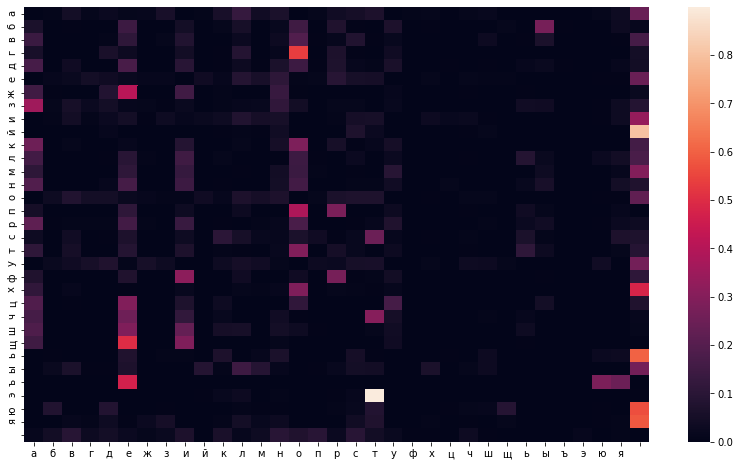

In [11]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

Чаще всего в романе встречаются буквы: 'е', 'о', 'а', 'и', а также пробел. Также из графика видно, что часто встречается сочетание букв 'эт'.

Формулы для вычисления вероятности перехода из одного состояния в другое в однородных марковских цепях.  
Также формула для вычисления вероятности слова из романа, состоящего из 4-х букв, начинающегося на 'п' и заканчивающегося буквой 'р'. Т.к. определяется вероятность слова, то по краям должны находиться пробелы.

$$P(X_n=j|X_0=i)=\dfrac{P(X_n=j,X_0=i)}{P(X_0=i)}=\sum \limits_{i_0,…,i_{n−1} \in E} \dfrac{P(X_0=i, X_1=i_1,...,X_{n-1}=i_{n-1}, X_n = j)}{P(X_0=i)}=\sum \limits_{i_0,…,i_{n−1} \in E} p_{ii_1}...p_{i_{n-1}j}$$  
  

  
  
  
  
$$P(X_5=`space`, X_4=`р`|X_1=`п`, X_0=`space`)=$$  
$$=\dfrac{P(X_0=i_0=i=`space`, X_1=i_1=`п`, X_2=i_2, X_3=i_3, X_4=i_4=`р`, X_5=i_5=j=`space`)}{P(X_0=`space`)}=$$  
$$=P(X_1=`п`|X_0=`space`)P(X_5=`space`|X_4=`р`)P(X_1=i_1=`п`, X_2=i_2, X_3=i_3, X_4=i_4=`р`)=$$  
$$=p_{ii_1}p_{i_4j}\cdot\sum \limits_{i_1,…,i_4 \in E} p_{i_1i_2}p_{i_2i_3}p_{i_3i_4},$$  
где события $i=j=`space`, i_1=`п`, i_4=`р`$

In [12]:
first = last = ' '
second = 'п'
penult = 'р'
prob = 0
p_i_i1 = probabilities[POS[first], POS[second]]
p_i4_j = probabilities[POS[penult], POS[last]]
for i_1 in E:
    p_i1_i2 = probabilities[POS[second], POS[i_1]]
    for i_2 in E:
        p_i2_i3 = probabilities[POS[i_1], POS[i_2]]
        for i_3 in E:
            p_i3_i4 = probabilities[POS[i_3], POS[penult]]
            prob += p_i_i1 * p_i1_i2 * p_i2_i3* p_i3_i4 * p_i4_j

In [13]:
prob

0.004039969554123586

Вероятность для слова 'п--р' 0.004%. 

---

Сгенерируем 8 символов, включая пробелы, начинающиеся на букву 'б'.

In [14]:
length = 7
first = 'б'
word = first
for i in range(length):
    cp_ind = POS[word[-1]]
    c_next = np.random.choice(list(E), p=probabilities[cp_ind])
    word += c_next

print(word)

бнорудаг


Сгенерируем слово из 8 букв (без пробелов), начинающееся на букву 'б'.

In [15]:
A = probabilities[0:32, 0:32]
B = probabilities[:-1, -1]/32
C = np.array([B for i in range(32)]).transpose()
probabilities_new = A + C

In [16]:
length = 7
first = 'б'
word = first
for i in range(length):
    cp_ind = POS[word[-1]]
    c_next = np.random.choice(list(E[:-1]), p=probabilities_new[cp_ind])
    word += c_next

print(word)

бшиэтобы


---

Для оценки марковской модели с переключениями возьмём ряд закрытия индексов Доу-Джонса. Оценим ряд и сделаем наивный прогноз. 

In [17]:
series = pd.read_csv('C:/Users/User/Desktop/Data Scientist/AML/Time_Series/Series/weekly-closings-of-the-dowjones-.csv')['Close']

In [18]:
values = series.values.reshape(-1,1)

In [19]:
for n in range(1, 15):
    model = hmm.GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -894.2620483582102
2 -820.6341453620573
3 -786.8374189914167
4 -752.0201472668964
5 -737.118111193092
6 -729.5671112589449
7 -713.7233991717006
8 -702.1073061994873
9 -690.9838068209652
10 -691.3313489290508


Fitting a model with 167 free scalar parameters with only 162 data points will result in a degenerate solution.


11 -679.0462088267415


Fitting a model with 194 free scalar parameters with only 162 data points will result in a degenerate solution.


12 -675.3629978088527


Fitting a model with 223 free scalar parameters with only 162 data points will result in a degenerate solution.


13 -659.7217307627243
14 -650.5368661368848


Fitting a model with 223 free scalar parameters with only 162 data points will result in a degenerate solution.


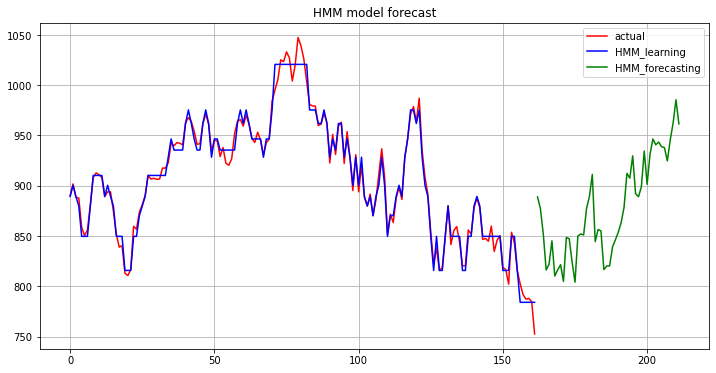

In [20]:
model = hmm.GaussianHMM(n_components=14,
                        covariance_type='diag',
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]

X, Z = model.sample(50)
forecast = np.empty_like(series)
forecast[:] = np.nan
forecast = np.append(forecast, X)

plt.figure(figsize=(12, 6))
plt.plot(values, 'r', label='actual')
plt.plot(means, 'b', label='HMM_learning')
plt.plot(forecast, 'g', label='HMM_forecasting')
plt.legend(loc='best')
plt.title("HMM model forecast")
plt.grid(True);